<a href="https://colab.research.google.com/github/Divyacanny22/Divyacanny22/blob/main/fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries

import torch
from torch import nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor

from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler #for validation textdta


# Import matplotlib for visualization
import matplotlib.pyplot as plt 


# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [ ]:
#Transformation of images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5),)])

### Get data

In [ ]:
#setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to ?
    train=True, # do we want training dataset ?
    download=True, # do we want to download yes/no ?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data ?
    target_transform=None # how do we want to transforms the labels/targets ?
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor(),
    target_transform=None
) 

100%|██████████| 26421880/26421880 [00:01<00:00, 16480138.05it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 298339.74it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5478915.19it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5692664.64it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_data = datasets.FashionMNIST('`/.pytorch/F_MNIST_data',download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('`/.pytorch/F_MNIST_data',download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 16339217.60it/s]


Extracting `/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to `/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 312164.80it/s]


Extracting `/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to `/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5461541.32it/s]


Extracting `/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to `/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14628913.95it/s]


Extracting `/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to `/.pytorch/F_MNIST_data/FashionMNIST/raw



In [ ]:
#validation test preparation
indices = list(range(len(train_data)))
np.random.shuffle(indices)
#split the dataset in such a way that ,80% of the dataset used for training and 20%  for  validation
split = int(np.floor(0.2 * len(train_data)))
train_sample = SubsetRandomSampler(indices[:split])
val_sample = SubsetRandomSampler(indices[split:])



## Data loader

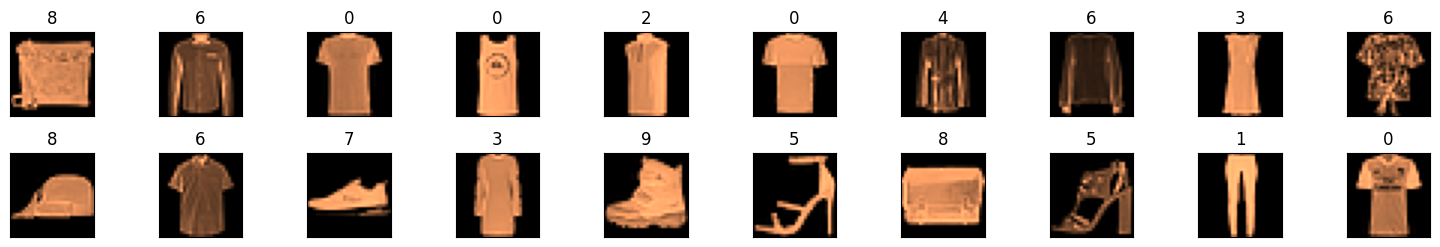

In [ ]:
# Data loader to load the dataset in batch mode
train_loader =torch.utils.data.DataLoader(train_data,sampler=train_sample,batch_size=64)
validate_loader =torch.utils.data.DataLoader(train_data,sampler=val_sample,batch_size=64)
test_loader =torch.utils.data.DataLoader(test_data,batch_size=64, shuffle=True)

iterations = iter(train_loader)
print(iterations)
images, labels = next(iterations)

fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4,10, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap="copper")
  ax.set_title(labels[idx].item())
  fig.tight_layout()



In [ ]:
#Define the linear layer with normalization techniques
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,120)
    self.fc2 = nn.Linear(120,120)
    self.fc3 = nn.Linear(120,10)
    self.dropout = nn.Dropout(0,3)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.log_softmax(self.fc3(x), dim=1)
    return x

In [ ]:
model = Classifier()
# defining the loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

val_loss_min = np.Inf
epochs = 20
steps = 0
#prep  the model for training
model.train()
train_losses, val_losses = [],[]
for e in range(epochs):
  running_loss = 0
  val_loss = 0
  # train the model
  for images, labels in train_loader:

    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*images.size(0)

  for images, labels in validate_loader:
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    val_loss += loss.item()*images.size(0)

  running_loss = running_loss/len(train_loader.sampler)
  val_loss = val_loss/len(validate_loader.sampler)
  train_losses.append(running_loss)
  val_losses.append(running_loss)

  print('Epoch: {} \Training Loss: {:.6f} \tValidation Loss: {:6f}'.format(
      e+1,
      running_loss,
      val_loss
  ))
  if val_loss <= val_loss_min:
    print('validation loss decreased({:.6f} -->{:6f}).Saving Model ...'.format(val_loss_min, val_loss))
    torch.save(model.state_dict(), 'model.pt')
    val_loss_min = val_loss



Epoch: 1 \Training Loss: 1.857397 	Validation Loss: 1.300730
validation loss decreased(inf -->1.300730).Saving Model ...
Epoch: 2 \Training Loss: 1.025813 	Validation Loss: 0.846822
validation loss decreased(1.300730 -->0.846822).Saving Model ...
Epoch: 3 \Training Loss: 0.776461 	Validation Loss: 0.710893
validation loss decreased(0.846822 -->0.710893).Saving Model ...
Epoch: 4 \Training Loss: 0.683945 	Validation Loss: 0.648311
validation loss decreased(0.710893 -->0.648311).Saving Model ...
Epoch: 5 \Training Loss: 0.633194 	Validation Loss: 0.609641
validation loss decreased(0.648311 -->0.609641).Saving Model ...
Epoch: 6 \Training Loss: 0.597278 	Validation Loss: 0.587147
validation loss decreased(0.609641 -->0.587147).Saving Model ...
Epoch: 7 \Training Loss: 0.569406 	Validation Loss: 0.557842
validation loss decreased(0.587147 -->0.557842).Saving Model ...
Epoch: 8 \Training Loss: 0.546177 	Validation Loss: 0.539146
validation loss decreased(0.557842 -->0.539146).Saving Model .

plot the graph between training loss/val loss vs iteration(epoch)

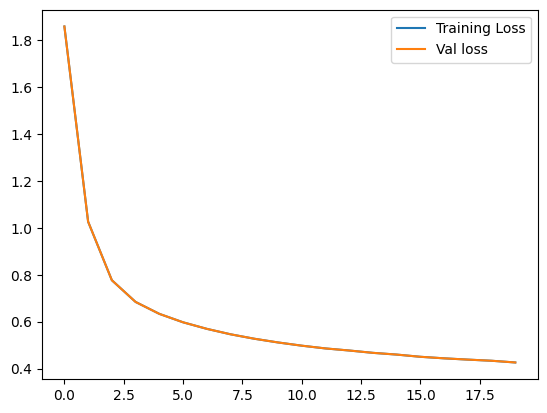

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Val loss')
plt.legend()

##        save the model to model.pt in current working directory

## Test Accuracy and Test loss computation

In [ ]:
# track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0.for i in range(10))

model.eval()
for images, labels in test_loader:
  #forward pass
  output = model(images)
  #calculate the loss
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  # convert outpurt probabilities to predicted class
  _, pred = torch.max(output,1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calculate and print test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] >0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
          
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d/%% (%2d/%2d)' %(
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))            



Test Loss: 0.479316

Test Accuracy of     0: 79% (798/1000)
Test Accuracy of     1: 95% (951/1000)
Test Accuracy of     2: 65% (653/1000)
Test Accuracy of     3: 83% (832/1000)
Test Accuracy of     4: 83% (839/1000)
Test Accuracy of     5: 89% (890/1000)
Test Accuracy of     6: 53% (537/1000)
Test Accuracy of     7: 92% (929/1000)
Test Accuracy of     8: 93% (938/1000)
Test Accuracy of     9: 91% (912/1000)

Test Accuracy (Overall): 82/% (8279/10000)


## Convert the model to ONNX formad (conversion from.pt to .onnx)

In [ ]:
dummy_input = torch.randn(1,28,28)
input_names = ["actual_input"]
output_names = ["output"]
torch.onnx.export(model,
                  dummy_input,
                  "fashion_mnist.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



OnnxExporterError: ignored

## Save the trained model (asset) onto WML reposiory

save your model onto watson machine learning repository by using the IBM watson machine learning SDK.


In [ ]:
software_spec_uid = client.software_specifications.get_id_by_name("runtime-22.1-py3.11")


In [ ]:
saved_model_def = "model.pt"
saved_onnx_model = "fashion_mnist.onnx"

import tarfile, os

tar_gz_file = 'fashion_mnist.tar.gz'
if os.path.exists(tar_gz_file):
  os.remove(tar_gz_file)

#onnx_model_file = 'mnist_cnn_131.onnx'
onnx_model_file = 'fashion_mnist.onnx'

with tarfile.open(tar_gz_file, "w:gz") as tar:
  tar.add(onnx_model_file, arcname=onnx_model_file)



In [ ]:
!ls -ltr $tar_gz_file

In [ ]:
# store the model
saved_model_file = tar_gz_file
metadata = {
    client.repository.ModelMetaNames.NAME: 'fashion_MNIST pytorch model',
    client.repository.ModelMetaNames.TYPE: 'pytorch-onnx_1.10',
    client.repository.ModelMetaNames.software_spec_UID: 'software_spec_uid',
    
}

##Deploying the model and inference the model
Create a deployment based on published model


In [ ]:
metadata =